# Google Stock Forecasting in PyTorch using LSTM Neural Network

### Introduction

In this notebook, we'll explore the process of building a stock price forecasting model using a Long Short-Term Memory (LSTM) neural network. We'll focus on predicting Google's stock prices based on historical data. 

LSTMs are a type of recurrent neural network (RNN) that excel at capturing temporal dependencies in sequential data, making them well-suited for time series forecasting tasks.

Historical Data for Google was downloaded from [Yahoo Finance](https://finance.yahoo.com/quote/GOOG/history?p=GOOG)

### Table of Contents

1. [Importing Libraries](#importing-libraries)
2. [Importing Data](#importing-data)
3. [Selecting Device](#selecting-device)
4. [Converting Data Types](#converting-data-types)
5. [Exploratory Data Analysis](#exploratory-data-analysis)
6. [Selecting Data](#selecting-data)
7. [Preparing Data for LSTM](#preparing-data-for-lstm)
8. [Splitting Data into Train and Test Sets](#splitting-data-into-train-and-test-sets)
9. [Reshaping Data for LSTM](#reshaping-data-for-lstm)
10. [Creating the Dataset](#creating-the-dataset)
11. [Defining the LSTM Model](#defining-the-lstm-model)
12. [Training the Model](#training-the-model)
13. [Evaluating Model Performance on Test Data](#evaluating-model-performance-on-test-data)
14. [Define Hyperparameters & Running The Training Loop](#defining-hyperparameters-&-running-the-training-loop)
15. [Visualizing Predictions](#visualizing-predictions)
16. [Evaluating Model Performance Metrics](#evaluating-model-performance-metrics)


### 1. Importing Libraries <a id="importing-libraries"></a>

In [1]:
# Importing libraries for data manipulation and analysis
import pandas as pd         # For working with data in tabular format (DataFrames)
import numpy as np          # For numerical computations and array manipulation
from copy import deepcopy as dc  # Used to create deep copies of objects

# Importing libraries for data visualization
import matplotlib.pyplot as plt   # For creating visualizations and plots
import seaborn as sns             # For creating more advanced and aesthetic visualizations

# Importing libraries for data preprocessing and splitting
from sklearn.preprocessing import MinMaxScaler   # For scaling and normalizing data
from sklearn.model_selection import train_test_split  # For splitting data into train and test sets

# Importing libraries for machine learning with PyTorch
import torch                 # PyTorch library for building and training neural networks
import torch.nn as nn        # PyTorch's neural network module

# Importing libraries for defining custom datasets and evaluation metrics
from torch.utils.data import Dataset   # PyTorch's Dataset class for custom data loading
from torch.utils.data import DataLoader   # PyTorch's Dataset class for data loading
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error  # Evaluation metrics

### [Back to Table of Contents](#Table-of-Contents)

### 2. Importing Data <a id="importing-data"></a>

We load the Google stock price data from a CSV file. This data has been taken from Yahoo Finance.

In [2]:
df = pd.read_csv('GOOG.csv')

### [Back to Table of Contents](#Table-of-Contents)

### 3. Selecting Device <a id="selecting-device"></a>

We determine whether to use a GPU (cuda) or CPU for computations.

In [3]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

### [Back to Table of Contents](#Table-of-Contents)

### 4. Converting Data Types <a id="converting-data-types"></a>

In [4]:
# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

### [Back to Table of Contents](#Table-of-Contents)

### 5. Exploratory Data Analysis <a id="exploratory-data-analysis"></a>

Here, we perform exploratory data analysis to understand the dataset:

- Display basic information and summary statistics.
- Plotting time series data.
- Visualizing correlations using a heatmap.
- Visualizing the distribution of closing prices.
- Creating box plots of closing prices by year.
- Creating a pairwise relationships plot.

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4763 entries, 0 to 4762
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    4763 non-null   datetime64[ns]
 1   Open    4763 non-null   float64       
 2   High    4763 non-null   float64       
 3   Low     4763 non-null   float64       
 4   Close   4763 non-null   float64       
 5   Volume  4763 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 223.4 KB
None

Summary Statistics:
              Open         High          Low        Close        Volume
count  4763.000000  4763.000000  4763.000000  4763.000000  4.763000e+03
mean     39.856566    40.280553    39.448954    39.871618  1.205669e+08
std      36.876570    37.304573    36.489481    36.900098  1.516963e+08
min       2.470490     2.534002     2.464263     2.490913  1.584340e+05
25%      12.735639    12.884829    12.627543    12.753198  2.914

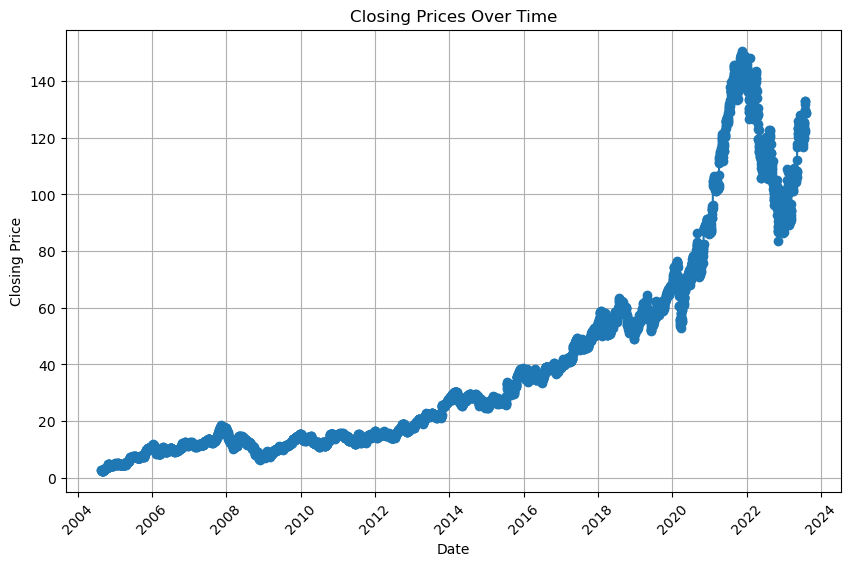

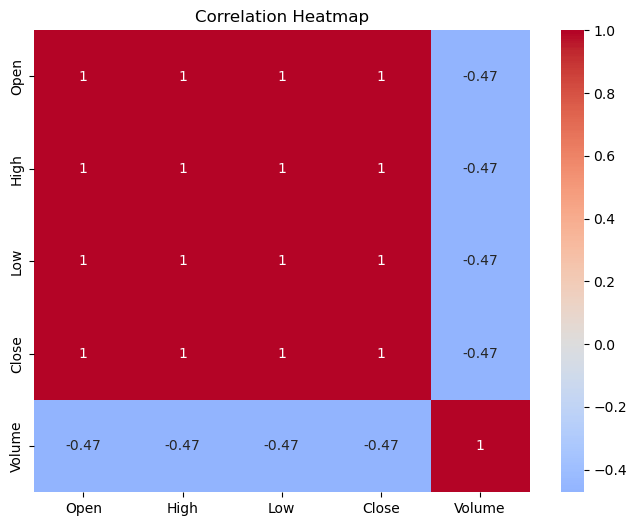

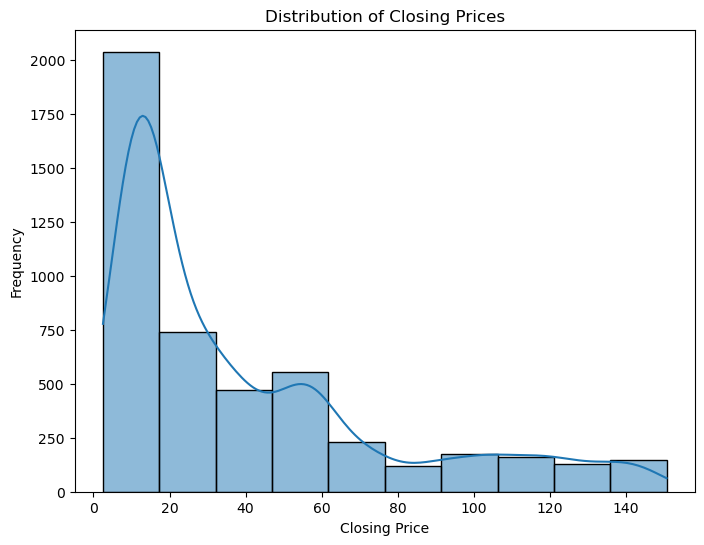

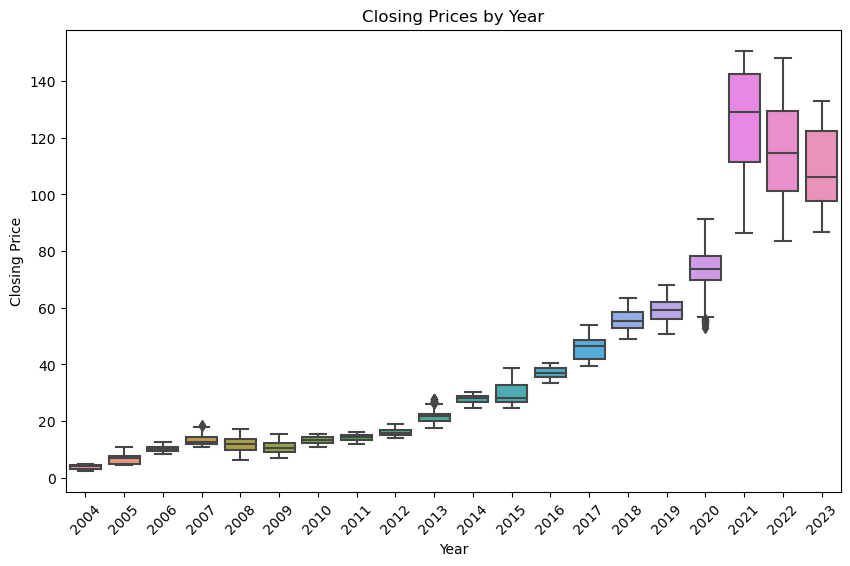

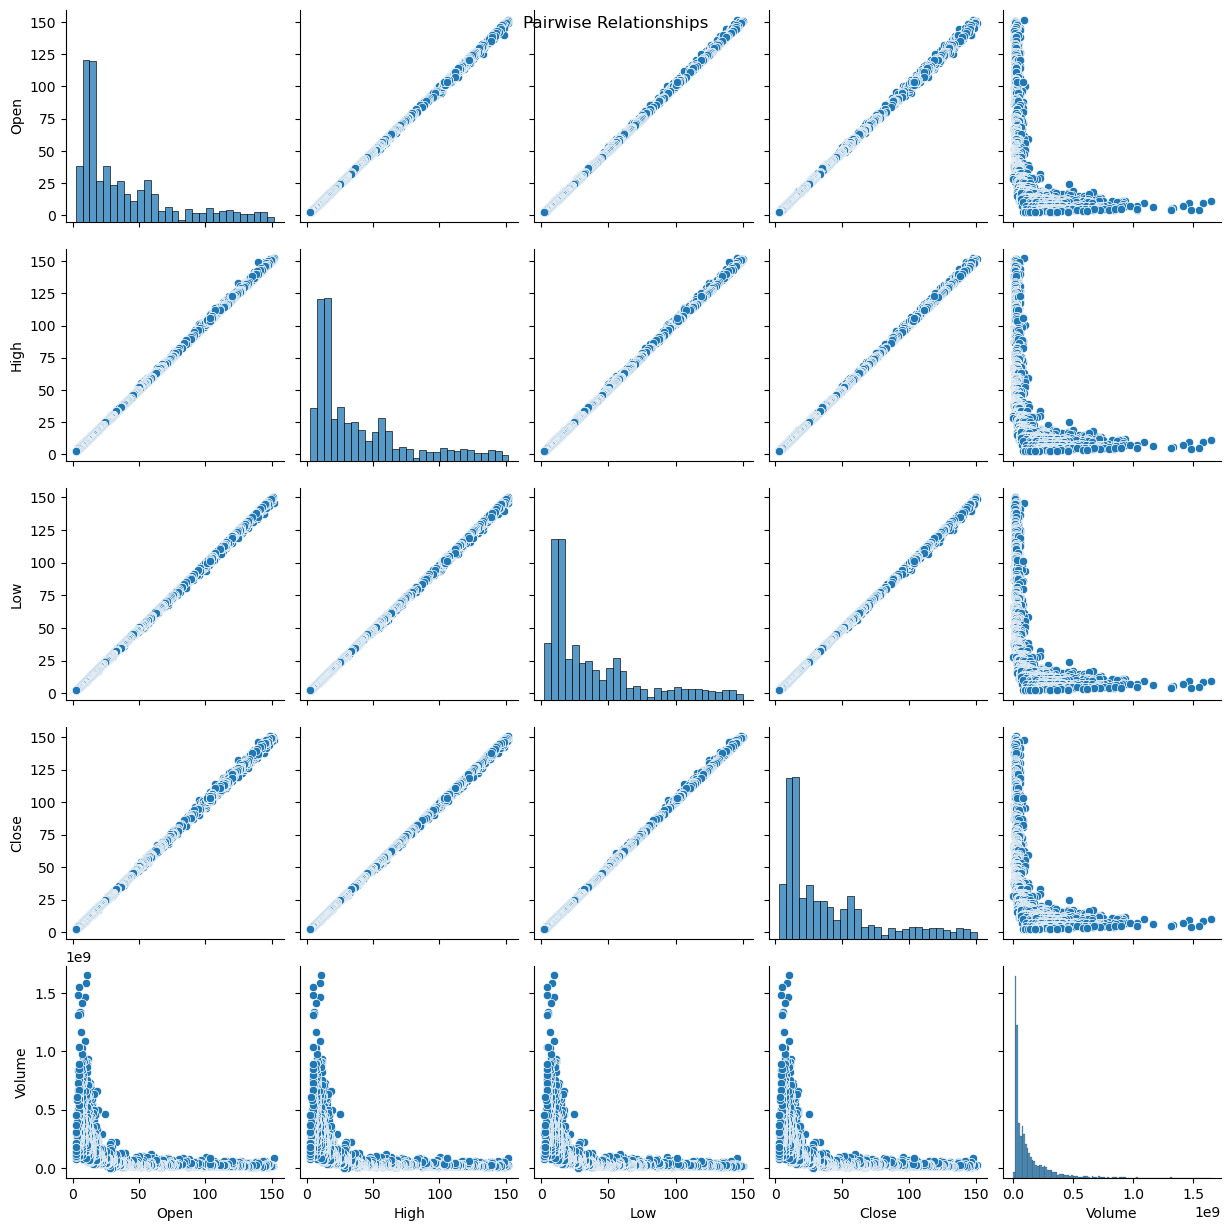

In [5]:
# Display basic information about the dataset
print("Dataset Information:")
print(df.info())

# Display summary statistics of the numeric columns
print("\nSummary Statistics:")
print(df.describe())

# Plotting time series data
plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['Close'], marker='o')
plt.title("Closing Prices Over Time")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Visualizing correlation using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Heatmap")
plt.show()

# Distribution of closing prices
plt.figure(figsize=(8, 6))
sns.histplot(df['Close'], bins=10, kde=True)
plt.title("Distribution of Closing Prices")
plt.xlabel("Closing Price")
plt.ylabel("Frequency")
plt.show()

# Box plot of closing prices by year
df['Year'] = df['Date'].dt.year
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Year', y='Close')
plt.title("Closing Prices by Year")
plt.xlabel("Year")
plt.ylabel("Closing Price")
plt.xticks(rotation=45)
plt.show()

# Pairplot to visualize relationships between variables
sns.pairplot(df[['Open', 'High', 'Low', 'Close', 'Volume']])
plt.suptitle("Pairwise Relationships")
plt.show()

### [Back to Table of Contents](#Table-of-Contents)

### 6. Selecting Data <a id="selecting-data"></a>

We select the relevant columns ('Date' and 'Close') from the dataset for further processing.

In [6]:
data = df[['Date', 'Close']]

### [Back to Table of Contents](#Table-of-Contents)

### 7. Preparing Data for LSTM <a id="preparing-data-for-lstm"></a>

We create a function that prepares the data by adding lagged 'Close' prices as features, setting the 'Date' column as the index, and handling missing values.

In [7]:
def prepare_dataframe_for_lstm(df, n_steps):
    """
    Prepare the DataFrame for LSTM input by adding lagged 'Close' prices as features.

    Args:
    df (DataFrame): The original DataFrame containing the data.
    n_steps (int): Number of time steps for the lagged features.

    Returns:
    DataFrame: A new DataFrame with added lagged 'Close' prices as features.
    """
    # Create a copy of the DataFrame to avoid modifying the original data
    df = dc(df)
    
    # Set the 'Date' column as the index for time-based operations
    df.set_index('Date', inplace=True)
    
    # Add lagged 'Close' prices as new columns
    for i in range(n_steps, 0, -1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)
        
    # Remove rows with missing values (introduced by shifting)
    df.dropna(inplace=True)
    
    return df

In [8]:
# Define the number of time steps (lookback window) for lagged features
lookback = 7

# Prepare the DataFrame for LSTM input by adding lagged features
shifted_df = prepare_dataframe_for_lstm(data, lookback)

# Display the modified DataFrame with lagged 'Close' prices as features
shifted_df

,Close,Close(t-7),Close(t-6),Close(t-5),Close(t-4),Close(t-3),Close(t-2),Close(t-1)
Date,,,,,,,,
2023-07-25,122.790000,128.770000,128.640000,131.890000,133.110000,133.010000,129.870000,129.660000
2023-07-24,121.880000,128.640000,131.890000,133.110000,133.010000,129.870000,129.660000,122.790000
2023-07-21,120.310000,131.890000,133.110000,133.010000,129.870000,129.660000,122.790000,121.880000
2023-07-20,119.530000,133.110000,133.010000,129.870000,129.660000,122.790000,121.880000,120.310000
2023-07-19,122.780000,133.010000,129.870000,129.660000,122.790000,121.880000,120.310000,119.530000
...,...,...,...,...,...,...,...,...
2004-08-26,2.687676,2.530017,2.490913,2.528273,2.496891,2.549693,2.540727,2.643840
2004-08-25,2.640104,2.490913,2.528273,2.496891,2.549693,2.540727,2.643840,2.687676
2004-08-24,2.611960,2.528273,2.496891,2.549693,2.540727,2.643840,2.687676,2.640104


In [9]:
# Convert the prepared DataFrame with lagged features to a NumPy array
shifted_df_as_np = shifted_df.to_numpy()

# Display the resulting NumPy array containing the data with lagged features
shifted_df_as_np

array([[122.79    , 128.77    , 128.64    , ..., 133.01    , 129.87    ,
        129.66    ],
       [121.88    , 128.64    , 131.89    , ..., 129.87    , 129.66    ,
        122.79    ],
       [120.31    , 131.89    , 133.11    , ..., 129.66    , 122.79    ,
        121.88    ],
       ...,
       [  2.61196 ,   2.528273,   2.496891, ...,   2.64384 ,   2.687676,
          2.640104],
       [  2.724787,   2.496891,   2.549693, ...,   2.687676,   2.640104,
          2.61196 ],
       [  2.697639,   2.549693,   2.540727, ...,   2.640104,   2.61196 ,
          2.724787]])

In [10]:
# Initialize the MinMaxScaler with a feature range of (-1, 1)
# This scaler scales and transforms the data to a specified range, commonly used to normalize features.
scaler = MinMaxScaler(feature_range=(-1, 1))

# Apply MinMax scaling to the numpy array containing lagged features and target
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

# Extract the lagged features (X) and target variable (y) from the scaled data
X = shifted_df_as_np[:, 1:]  # Lagged features are columns from index 1 onwards
y = shifted_df_as_np[:, 0]   # Target variable is the first column

# Display the shapes of agged features (X) and target variable (y) arrays
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (4756, 7)
Shape of y: (4756,)


### [Back to Table of Contents](#Table-of-Contents)

### 8. Splitting Data into Train and Test Sets <a id="splitting-data-into-train-and-test-sets"></a>

We split the data into training and testing sets, with a 95% training and 5% testing split.

In [11]:
# Split the data into 95% training and 5% testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=0, shuffle=False)

# Display the shapes of the training and testing sets
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (4518, 7)
Shape of y_train: (4518,)
Shape of X_test: (238, 7)
Shape of y_test: (238,)


### [Back to Table of Contents](#Table-of-Contents)

### 9. Reshaping Data for LSTM <a id="reshaping-data-for-lstm"></a>

The LSTM model expects input data to be in the shape (batch_size, sequence_length, input_size). We reshape the data to match this format.

In [12]:
# Reshape the training and testing data to fit the expected input shape for LSTM in PyTorch
# LSTM requires input in the shape (batch_size, sequence_length, input_size)

# Reshape X_train to have dimensions: (batch_size, sequence_length, input_size)
X_train = X_train.reshape((-1, lookback, 1))

# Reshape X_test to have dimensions: (batch_size, sequence_length, input_size)
X_test = X_test.reshape((-1, lookback, 1))

# Reshape y_train to have dimensions: (batch_size, output_size)
y_train = y_train.reshape((-1, 1))

# Reshape y_test to have dimensions: (batch_size, output_size)
y_test = y_test.reshape((-1, 1))

# Display the shapes of the reshaped training and testing sets
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (4518, 7, 1)
Shape of X_test: (238, 7, 1)
Shape of y_train: (4518, 1)
Shape of y_test: (238, 1)


In [13]:
# Convert the training and testing data to PyTorch tensors and set their data type to float
# This is important because PyTorch requires tensor data types to be consistent and compatible with the operations being performed.

# Convert X_train to a PyTorch tensor and set its data type to float
X_train = torch.tensor(X_train).float()

# Convert y_train to a PyTorch tensor and set its data type to float
y_train = torch.tensor(y_train).float()

# Convert X_test to a PyTorch tensor and set its data type to float
X_test = torch.tensor(X_test).float()

# Convert y_test to a PyTorch tensor and set its data type to float
y_test = torch.tensor(y_test).float()

# Display the shapes of the PyTorch tensors
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: torch.Size([4518, 7, 1])
Shape of X_test: torch.Size([238, 7, 1])
Shape of y_train: torch.Size([4518, 1])
Shape of y_test: torch.Size([238, 1])


### [Back to Table of Contents](#Table-of-Contents)

### 10. Creating the Dataset <a id="creating-the-dataset"></a>

We define a custom Dataset class to encapsulate the training and testing data for easy loading into PyTorch's DataLoader.

In [14]:
# Define a custom Dataset class for time series data
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        """
        Initialize the TimeSeriesDataset.

        Args:
        X (Tensor): Input data tensor.
        y (Tensor): Target data tensor.
        """
        self.X = X
        self.y = y

    def __len__(self):
        """
        Get the length of the dataset.

        Returns:
        int: Length of the dataset.
        """
        return len(self.X)

    def __getitem__(self, i):
        """
        Get a single sample from the dataset.

        Args:
        i (int): Index of the sample.

        Returns:
        Tuple: A tuple containing input data and target data.
        """
        return self.X[i], self.y[i]
    
# Create instances of the custom TimeSeriesDataset class for training and testing data
# This preparing the data to be used with PyTorch's DataLoader, which facilitates efficient batch-wise processing during model training
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

By creating and utilizing data loaders, you're preparing your data to be fed in batches to your machine learning model during training and testing. Data loaders help improve training efficiency, manage memory usage, and provide a convenient way to iterate over the data while training the model.

In [15]:
# Define the batch size for data loading
batch_size = 16

# Create DataLoader instances for training and testing data

# Create a DataLoader for training data
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Create a DataLoader for testing data
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [16]:
# Iterate over the batches in the training data loader
for _, batch in enumerate(train_loader):
    # Extract the input (x_batch) and target (y_batch) from the batch
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    
    # Print the shapes of the input and target batches
    print(x_batch.shape, y_batch.shape)
    
    # Break the loop after processing the first batch
    break

torch.Size([16, 7, 1]) torch.Size([16, 1])


### [Back to Table of Contents](#Table-of-Contents)

### 11. Defining the LSTM Model <a id="defining-the-lstm-model"></a>

LSTMs (Long Short-Term Memory) are a type of recurrent neural network (RNN) designed to capture long-range dependencies in sequential data. They are well-suited for time series prediction tasks like the one presented here.

We define a custom LSTM model class using the PyTorch nn.Module interface. This class includes an LSTM layer and a fully connected (linear) output layer.

In [17]:
# Define a custom LSTM model class
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        """
        Initialize the LSTM model.

        Args:
        input_size (int): Size of the input features.
        hidden_size (int): Number of LSTM units (hidden state size).
        num_stacked_layers (int): Number of stacked LSTM layers.
        """
        super().__init__()

        # Store the hidden state size and number of stacked layers as attributes
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        # Create an LSTM layer with the specified parameters
        # - 'input_size': Size of the input features.
        # - 'hidden_size': Number of LSTM units (hidden state size).
        # - 'num_stacked_layers': Number of stacked LSTM layers.
        # - 'batch_first=True': Input and output tensors have shape (batch_size, sequence_length, feature_dim).
        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, batch_first=True)

        # Create a fully connected (linear) layer to produce the final output
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        """
        Forward pass through the LSTM model.

        Args:
        x (Tensor): Input data tensor.

        Returns:
        Tensor: Model predictions.
        """
        batch_size = x.size(0)
        
        # Initialize initial hidden state (h0) and cell state (c0) tensors with zeros
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        
        # Pass the input through the LSTM layer, using initial hidden and cell states
        # - 'out': LSTM output tensor for each time step.
        # - '_': Tuple containing the final hidden state and cell state (not used in this case).
        out, _ = self.lstm(x, (h0, c0))
        
        # Select the output at the last time step and pass through the fully connected layer
        out = self.fc(out[:, -1, :])
        return out

# Create an instance of the custom LSTM model with specified parameters
model = LSTM(input_size=1, hidden_size=4, num_stacked_layers=1)

# Move the model to the specified device (e.g., GPU) for computation
model.to(device)

# Display the model architecture
print(model)

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)


### [Back to Table of Contents](#Table-of-Contents)

### 12. Training the Model <a id="training-the-model"></a>

We define a function to train the model for a specified number of epochs. During each epoch, we iterate through batches of training data, compute the loss, perform backpropagation, and update the model's parameters.

In [18]:
def train_one_epoch():
    """
    Train the model for one epoch using the training data.

    This function performs the forward and backward passes for each batch
    in the training data, updating the model's parameters.

    """
    # Set the model to training mode
    model.train(True)
    
    # Print the current epoch number
    print(f'Epoch: {epoch + 1}')
    
    # Initialize the running loss to keep track of the average loss across batches
    running_loss = 0.0
    
    # Iterate over batches in the training data loader
    for batch_index, batch in enumerate(train_loader):
        # Move the input and target batches to the specified device (e.g., GPU)
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        # Perform forward pass to get model predictions
        output = model(x_batch)
        
        # Calculate the loss between model predictions and actual target values
        loss = loss_function(output, y_batch)
        
        # Add the loss value to the running loss
        running_loss += loss.item()
        
        # Zero the gradients to prepare for backward pass
        optimizer.zero_grad()
        
        # Perform backward pass to compute gradients
        loss.backward()
        
        # Update the model's parameters using the computed gradients
        optimizer.step()

        # Print batch-wise loss every 100 batches
        if batch_index % 100 == 99:
            # Calculate the average loss across the last 100 batches
            avg_loss_across_batches = running_loss / 100
            
            # Print batch index and the average loss
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1, avg_loss_across_batches))
            
            # Reset the running loss for the next batch set
            running_loss = 0.0
    
    # Print a blank line after each epoch for clarity
    print()

### [Back to Table of Contents](#Table-of-Contents)

### 13. Evaluating Model Performance on Test Data <a id="evaluating-model-performance-on-test-data"></a>

We define a function to evaluate the model's performance on the test dataset for a single epoch. This function computes the validation loss by comparing the model's predictions with the actual test values.

In [19]:
def validate_one_epoch():
    """
    Validate the model's performance on the test dataset for one epoch.

    This function evaluates the model's predictions on the test dataset,
    calculates the average validation loss, and prints the result.

    """
    # Set the model to evaluation mode (no dropout, batch normalization, etc.)
    model.train(False)
    
    # Initialize the running loss to keep track of the cumulative loss across batches
    running_loss = 0.0
    
    # Iterate over batches in the test data loader
    for batch_index, batch in enumerate(test_loader):
        # Move the input and target batches to the specified device (e.g., GPU)
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        # Disable gradient calculations for validation (no parameter updates)
        with torch.no_grad():
            # Perform forward pass to get model predictions
            output = model(x_batch)
            
            # Calculate the loss between model predictions and actual target values
            loss = loss_function(output, y_batch)
            
            # Add the loss value to the running loss
            running_loss += loss.item()

    # Calculate the average loss across all test batches
    avg_loss_across_batches = running_loss / len(test_loader)
    
    # Print the average validation loss
    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

### [Back to Table of Contents](#Table-of-Contents)

### 14. Define Hyperparameters & Running The Training Loop <a id="defining-hyperparameters-&-running-the-training-loop"></a>

We define the hyperparameters and train the model

In [29]:
learning_rate = 0.001  # Learning rate for the optimizer
num_epochs = 50        # Number of training epochs

# Define loss function (Mean Squared Error)
loss_function = nn.MSELoss()

# Define optimizer (Adam optimizer)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Loop over the specified number of epochs
for epoch in range(num_epochs):
    # Train the model for one epoch
    train_one_epoch()
    
    # Validate the model's performance on the test dataset for the current epoch
    validate_one_epoch()

Epoch: 1
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000

Val Loss: 0.000
***************************************************

Epoch: 2
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000

Val Loss: 0.000
***************************************************

Epoch: 3
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000

Val Loss: 0.000
***************************************************

Epoch: 4
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000

Val Loss: 0.000
***************************************************

Epoch: 5
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000

Val Loss: 0.000
***************************************************

Epoch: 6
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000

Val Loss: 0.000
***************************************************

Epoch: 7
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000

Val Loss: 0.000
***************************************************

Epoch: 8
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000

Val Loss: 0.000
***************************************************



Visualize the actual and predicted closing prices of the training data using a line plot

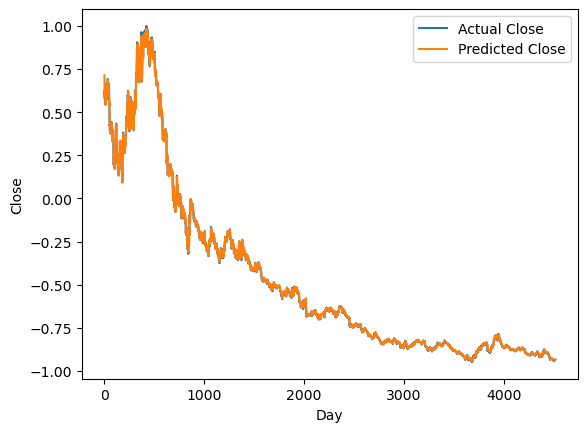

In [30]:
# Use torch.no_grad() to temporarily disable gradient calculations
with torch.no_grad():
    # Generate predictions for the training data using the trained model
    predicted = model(X_train.to(device)).to('cpu').numpy()

# Import the required plotting library
import matplotlib.pyplot as plt

# Plot the actual and predicted closing prices
plt.plot(y_train, label='Actual Close')      # Plot the actual closing prices
plt.plot(predicted, label='Predicted Close') # Plot the predicted closing prices
plt.xlabel('Day')                            # Set the x-axis label
plt.ylabel('Close')                          # Set the y-axis label
plt.legend()                                 # Display legend to differentiate actual and predicted
plt.show()                                   # Show the plot

### [Back to Table of Contents](#Table-of-Contents)

### 15. Visualizing Predictions <a id="visualizing-predictions"></a>

We visualize the actual and predicted closing prices for both the training and testing data using line plots.

#### Comparison of Actual and Predicted Training Data

In [31]:
# Post-process the predicted training data and convert it back to the original scale

# Flatten the predicted values into a 1D array
train_predictions = predicted.flatten()

# Create a dummy array for inverse transformation
# Shape: (number of samples, lookback + 1)
dummies = np.zeros((X_train.shape[0], lookback + 1))

# Fill the first column with the flattened predicted values
dummies[:, 0] = train_predictions

# Inverse transform the dummy array to revert scaling
dummies = scaler.inverse_transform(dummies)

# Extract the post-processed training predictions
train_predictions = dummies[:, 0]

In [32]:
# Post-process the actual training data and convert it back to the original scale

# Create a dummy array for inverse transformation
# Shape: (number of samples, lookback + 1)
dummies = np.zeros((X_train.shape[0], lookback + 1))

# Fill the first column with the flattened actual training values
dummies[:, 0] = y_train.flatten()

# Inverse transform the dummy array to revert scaling
dummies = scaler.inverse_transform(dummies)

# Extract the post-processed actual training values
new_y_train = dummies[:, 0]

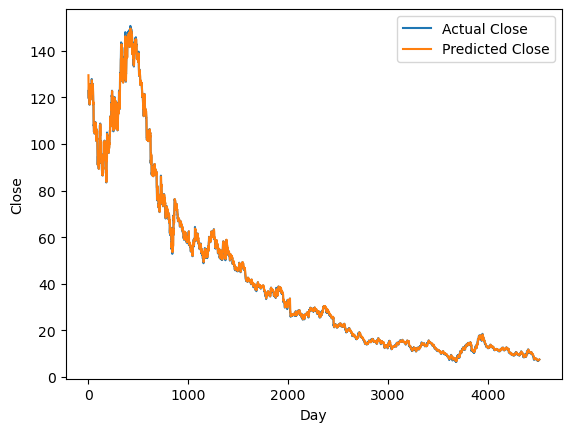

In [33]:
# Visualize the comparison of post-processed actual and predicted training data

# Plot the post-processed actual and predicted closing prices
plt.plot(new_y_train, label='Actual Close')      # Plot the post-processed actual closing prices
plt.plot(train_predictions, label='Predicted Close') # Plot the predicted closing prices
plt.xlabel('Day')                            # Set the x-axis label
plt.ylabel('Close')                          # Set the y-axis label
plt.legend()                                 # Display legend to differentiate actual and predicted
plt.show()                                   # Show the plot

### [Back to Table of Contents](#Table-of-Contents)

#### Comparison of Actual and Predicted Test Data

In [34]:
# Generate and post-process predictions for the test data

# Generate predictions for the test data using the trained model
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

# Create a dummy array for inverse transformation
# Shape: (number of samples, lookback + 1)
dummies = np.zeros((X_test.shape[0], lookback + 1))

# Fill the first column with the flattened predicted test values
dummies[:, 0] = test_predictions

# Inverse transform the dummy array to revert scaling
dummies = scaler.inverse_transform(dummies)

# Extract the post-processed test predictions
test_predictions = dummies[:, 0]

In [35]:
# Post-process the actual test data and convert it back to the original scale

# Create a dummy array for inverse transformation
# Shape: (number of samples, lookback + 1)
dummies = np.zeros((X_test.shape[0], lookback + 1))

# Fill the first column with the flattened actual test values
dummies[:, 0] = y_test.flatten()

# Inverse transform the dummy array to revert scaling
dummies = scaler.inverse_transform(dummies)

# Extract the post-processed actual test values
new_y_test = dummies[:, 0]

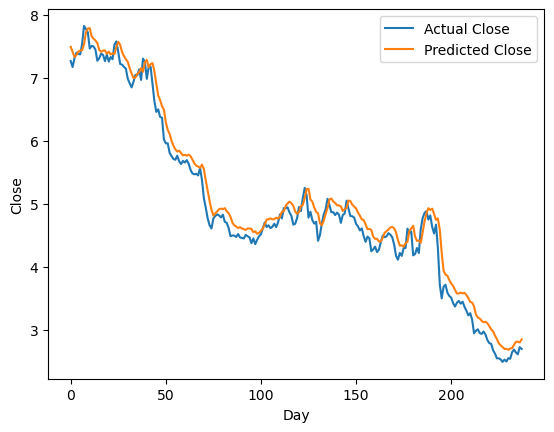

In [36]:
# Visualize the comparison of post-processed actual and predicted test data

# Plot the post-processed actual and predicted closing prices
plt.plot(new_y_test, label='Actual Close')       # Plot the post-processed actual closing prices
plt.plot(test_predictions, label='Predicted Close')  # Plot the predicted closing prices
plt.xlabel('Day')                               # Set the x-axis label
plt.ylabel('Close')                             # Set the y-axis label
plt.legend()                                    # Display legend to differentiate actual and predicted
plt.show()                                      # Show the plot

### [Back to Table of Contents](#Table-of-Contents)

### 16. Evaluating Model Performance Metrics <a id="evaluating-model-performance-metrics"></a>

We calculate and explain key performance metrics:

- R-squared: Indicates the proportion of variance in the dependent variable that the model can explain.
- Mean Absolute Error (MAE): Measures the average magnitude of errors between predicted and actual values.
- Mean Squared Error (MSE): Measures the average squared errors between predicted and actual values.

These metrics provide insights into how well the model's predictions align with the actual stock prices.

In [37]:
# Calculate R-squared
r2 = r2_score(new_y_test, test_predictions)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(new_y_test, test_predictions)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(new_y_test, test_predictions)

# Print the calculated metrics with explanations
print(f"R-squared: {r2:.3f}")
print(f"R-squared represents the proportion of the variance in the dependent variable that is predictable from the independent variables. "
      f"A value closer to 1 indicates a better fit.")

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"MAE measures the average magnitude of errors between predicted and actual values. "
      f"A lower MAE indicates better predictive accuracy.")

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"MSE measures the average squared errors between predicted and actual values. "
      f"A lower MSE indicates better predictive accuracy.")

R-squared: 0.976
R-squared represents the proportion of the variance in the dependent variable that is predictable from the independent variables. A value closer to 1 indicates a better fit.
Mean Absolute Error (MAE): 0.1786
MAE measures the average magnitude of errors between predicted and actual values. A lower MAE indicates better predictive accuracy.
Mean Squared Error (MSE): 0.0460
MSE measures the average squared errors between predicted and actual values. A lower MSE indicates better predictive accuracy.


### [Back to Table of Contents](#Table-of-Contents)